In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import glob
from pathlib import Path
import matplotlib.dates as mdates

DATA_DIR = Path("../data/daily_tardis/trades")
use_cols   = ["timestamp", "price", "amount"]          # keep memory light

Found 31 daily trade files
                         timestamp    price  amount
0 2025-01-01 00:00:03.428000+00:00  3331.10    9140
1 2025-01-01 00:00:16.147000+00:00  3330.35       6
2 2025-01-01 00:00:16.148000+00:00  3330.30       4
3 2025-01-01 00:00:16.602000+00:00  3329.60     618
4 2025-01-01 00:00:17.772000+00:00  3329.60     618


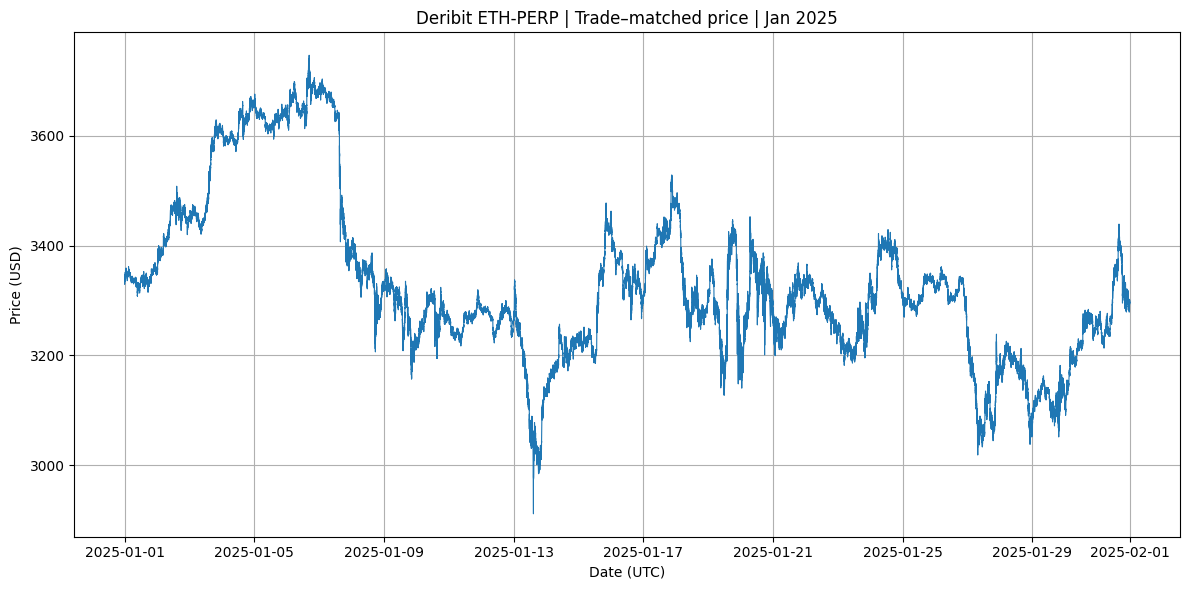

                                Value
Open (1 Jan)                 3,331.10
Close (31 Jan)               3,300.60
High                         3,746.60
Low                          2,911.70
Volume ETH           7,937,306,018.00
Volume USD      26,273,902,310,756.75


C:\Users\codri\AppData\Local\Temp\ipykernel_15036\2870369251.py:46: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(month_stats.applymap(lambda x: f"{x:,.2f}" if isinstance(x, float) else x))


In [12]:
# one file per day, e.g. 2025-01-01.csv.gz … 2025-01-31.csv.gz
files = sorted(glob.glob(str(DATA_DIR / "deribit_trades_2025-01-*_ETH-PERPETUAL.csv.gz")))
print(f"Found {len(files)} daily trade files")

# --- 2. Load & concatenate --------------------------------------------------
dfs = [
    pd.read_csv(f, compression="gzip", usecols=use_cols)
        .assign(timestamp=lambda d: pd.to_datetime(d.timestamp, unit='us', utc=True))
    for f in files
]

trades = (
    pd.concat(dfs, ignore_index=True)
      .sort_values("timestamp")
      .set_index("timestamp")
)
trades["notional"] = trades["price"] * trades["amount"]   # USD‑value of each fill

# --- 3. Daily OHLC + volumes -----------------------------------------------
daily_price   = trades["price"].resample("1D").ohlc()
daily_vol_qty = trades["amount"].resample("1D").sum()
daily_vol_usd = trades["notional"].resample("1D").sum()

# --- 4. Monthly summary -----------------------------------------------------



In [16]:
month_stats = pd.Series({
    "Open (1 Jan)":      trades["price"].iloc[0],
    "Close (31 Jan)":    trades["price"].iloc[-1],
    "High":              trades["price"].max(),
    "Low":               trades["price"].min(),
    "Quantity":        trades["amount"].sum(),
    "Volume USD":        trades["notional"].sum(),
}).to_frame("Value")
print(month_stats.map(lambda x: f"{x:,.2f}" if isinstance(x, float) else x))

                                Value
Open (1 Jan)                 3,331.10
Close (31 Jan)               3,300.60
High                         3,746.60
Low                          2,911.70
Quantity             7,937,306,018.00
Volume USD      26,273,902,310,756.75


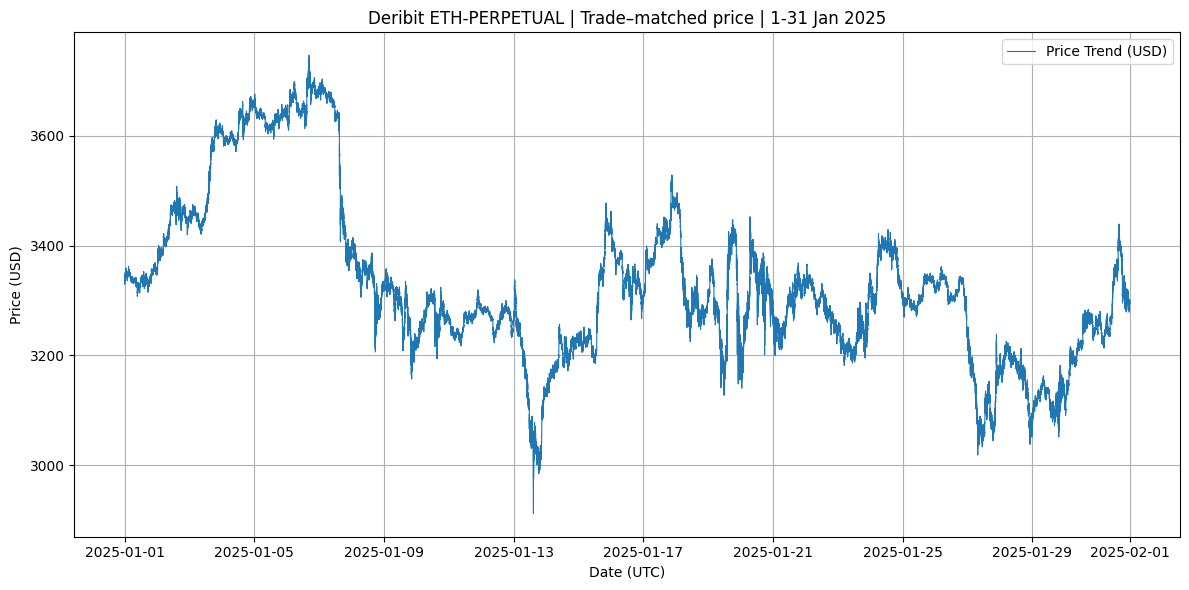

                                Value
Open (1 Jan)                 3,331.10
Close (31 Jan)               3,300.60
High                         3,746.60
Low                          2,911.70
Volume ETH           7,937,306,018.00
Volume USD      26,273,902,310,756.75


In [14]:
# --- 5. Plot ---------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(trades.index, trades["price"], linewidth=0.8)
plt.title("Deribit ETH‑PERPETUAL | Trade–matched price | 1-31 Jan 2025")
plt.legend(["Price Trend (USD)"])
plt.xlabel("Date (UTC)")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 6. Show stats table ----------------------------------------------------


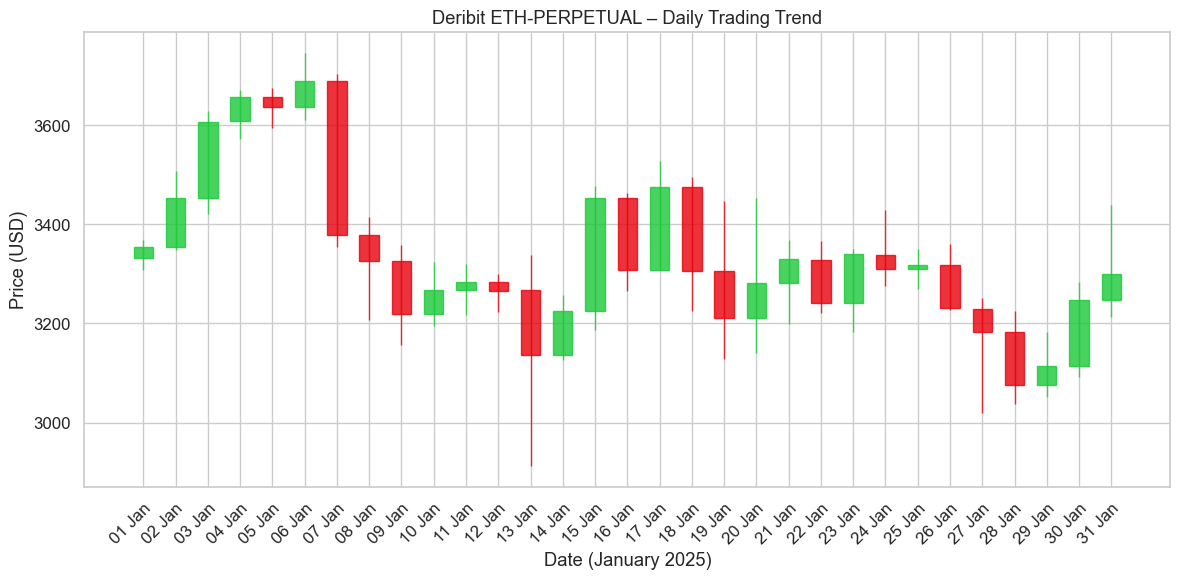

In [43]:
# --- 1. Prepare a seaborn look ---------------------------------------------
sns.set_theme(style="whitegrid", font_scale=1.1)            # global seaborn style
palette = sns.color_palette("bright", 8)                     # first → green, second → red
up_col, down_col = palette[2], palette[3]

# --- 2. Build a simple candlestick plot ------------------------------------
fig, ax = plt.subplots(figsize=(12, 6))

# x‑axis positions for each day
x = range(len(daily_price))

# Iterate over each day and draw:
width = 0.6                         # width of the candle body
for idx, day in enumerate(daily_price.itertuples()):
    o, h, l, c = day.open, day.high, day.low, day.close
    color = up_col if c >= o else down_col

    # Wick (high–low line)
    ax.vlines(idx, l, h, linewidth=1, color=color, alpha=0.8)
    # Body (open–close rectangle)
    lower = min(o, c)
    height = abs(c - o)
    # A tiny height (flat day) still needs a visible rectangle
    body = Rectangle((idx - width/2, lower),
                     width, max(height, 1e-5),
                     facecolor=color, edgecolor=color, alpha=0.8)
    ax.add_patch(body)

# --- 3. Decorations ---------------------------------------------------------
ax.set_xticks(x)   # one tick for every day (Jan 1 → Jan 31)
ax.set_xticklabels(
    [d.strftime("%d %b") for d in daily_price.index],   # 01 Jan … 31 Jan
    rotation=45,                   # diagonal labels
    ha="right",                    # right‑align so the text sits nicely
    rotation_mode="anchor"         # anchor at the right end
)

ax.set_title("Deribit ETH-PERPETUAL – Daily Trading Trend")
ax.set_ylabel("Price (USD)")
ax.set_xlabel("Date (January 2025)")

plt.tight_layout()
plt.savefig("../plots/candle_jan_2025.png", dpi=300, bbox_inches="tight")
plt.show()

C:\Users\codri\AppData\Local\Temp\ipykernel_15036\2316792460.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  trend = trades["price"].resample("10T").last()    # pandas Series with DateTimeIndex
C:\Users\codri\AppData\Local\Temp\ipykernel_15036\2316792460.py:50: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\codri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


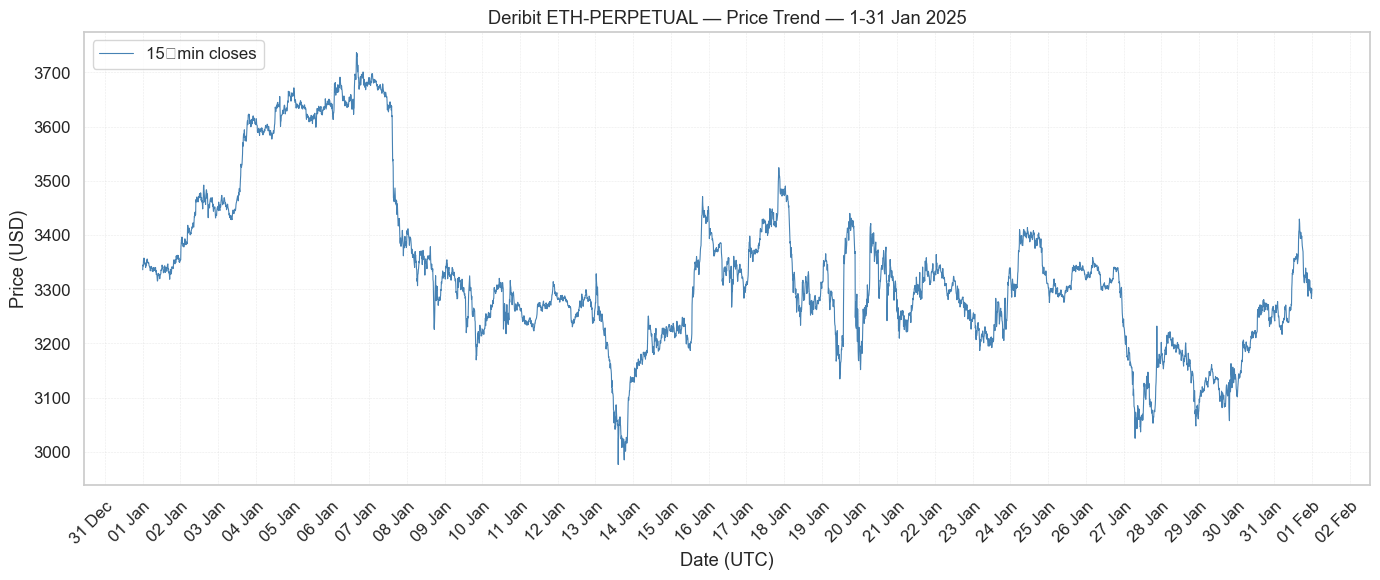

In [37]:

# ---------------------------------------------------------------------------
# 0. Styling — same seaborn look as before
# ---------------------------------------------------------------------------
sns.set_theme(style="whitegrid", font_scale=1.1)

# ---------------------------------------------------------------------------
# 1. Build a smoother trend line (optional but recommended)
#    • Here we take the LAST trade in every 15‑minute bucket to reduce noise.
#    • Change '15T' → '1T' if you really want every minute, or drop the resample
#      entirely if you’re happy to plot every tick (can be heavy on memory).
# ---------------------------------------------------------------------------
trend = trades["price"].resample("10T").last()    # pandas Series with DateTimeIndex

# ---------------------------------------------------------------------------
# 2. Plot
# ---------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    x=trend.index,
    y=trend.values,
    ax=ax,
    linewidth=0.8,
    color="steelblue",
    label="15‑min closes"
)

# ---------------------------------------------------------------------------
# 3. Decorations — identical x‑axis label format
# ---------------------------------------------------------------------------
# Major ticks every single day
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))

# Rotate & right‑align so labels sit neatly under ticks
plt.setp(
    ax.get_xticklabels(),
    rotation=45,
    ha="right",
    rotation_mode="anchor"
)

ax.set_title("Deribit ETH-PERPETUAL — Price Trend — 1-31 Jan 2025")
ax.set_ylabel("Price (USD)")
ax.set_xlabel("Date (UTC)")

ax.grid(True, which="both", linestyle="--", linewidth=0.4, alpha=0.4)
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()